In [1]:
cd ..

C:\Users\Nghia\PycharmProjects\ECML\Refactor


In [2]:
from pprint import pprint

import numpy as np
import tensorflow as tf
import time
from collections import Counter

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from load_datasets import mnist
from metrics import metrics
from models.AE1SVM import AEOneClassSVM
from models.DEC import DEC
from models.RDA import RobustL21Autoencoder


c:\users\nghia\anaconda2\envs\tf36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.set_random_seed(2018)

x_train, y_train, x_test, y_test = mnist(random_state=3)

counter = Counter(y_train)
print('Anomalies ratio:', 100*counter[-1]/(counter[1]+counter[-1]), '%')

c:\users\nghia\anaconda2\envs\tf36\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Anomalies ratio: 1.682935038707506 %


In [4]:
# Train conventional OCSVM
print('OCSVM-RBF')
libsvm = OneClassSVM(nu=0.13, verbose=True, shrinking=True)
t0 = time.time()
libsvm.fit(x_train)
print('Train time:', time.time() - t0)

t0 = time.time()
out_y = libsvm.predict(x_test)
print('Test time:', time.time() - t0)
pprint(metrics(y_test, out_y))

OCSVM-RBF
[LibSVM]Train time: 3.4817512035369873
Test time: 1.6529710292816162
{'AUPRC': 0.081902971223974,
 'AUROC': 0.8300890106128038,
 'Confusion matrix': array([[  39,   11],
       [ 350, 2571]], dtype=int64),
 'F1': 0.17767653758542143,
 'Precision': 0.10025706940874037,
 'Recall': 0.78}


In [5]:
# Train Isolation Forest
print('IsolationForest')
iforest = IsolationForest(contamination=0.15, verbose=1)
t0 = time.time()
iforest.fit(x_train)
print('Train time:', time.time() - t0)

t0 = time.time()
out_y = iforest.predict(x_test)
print('Test time:', time.time() - t0)
pprint(metrics(y_test, out_y))

IsolationForest


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


Train time: 8.271250247955322
Test time: 3.001840829849243
{'AUPRC': 0.0571079872021638,
 'AUROC': 0.7693050325231086,
 'Confusion matrix': array([[  34,   16],
       [ 413, 2508]], dtype=int64),
 'F1': 0.1368209255533199,
 'Precision': 0.07606263982102908,
 'Recall': 0.68}


In [6]:
batch_size = 32
autoencoder_layers = [784, 256, 128]

data_input = tf.placeholder(tf.float32, shape=[None, 784])

In [7]:
import matplotlib
import matplotlib.pyplot as plt

normal = x_test[np.where(y_test == 1)]
anomalies = x_test[np.where(y_test == -1)]

In [8]:
ae1svm = AEOneClassSVM(data_input, batch_size, 'test_normal', autoencoder_layers[1:], 0.4, 1e3, 3.0, 1000,
                       autoencoder_activation='sigmoid', seed=1,
                       full_op=tf.train.AdamOptimizer(1e-3),
                       svm_op=tf.train.AdamOptimizer(1e-4))

Combined train
........................................SVM train
Train time: 76.80531001091003
Test time: 0.18098187446594238
{'AUPRC': 0.06461200131008277,
 'AUROC': 0.8356829852790141,
 'Confusion matrix': array([[  43,    7],
       [ 551, 2370]], dtype=int64),
 'F1': 0.13354037267080746,
 'Precision': 0.0723905723905724,
 'Recall': 0.86}


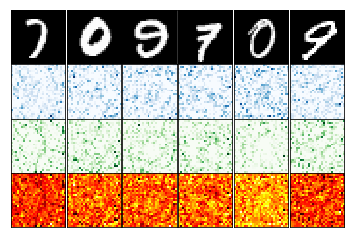

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Autoencoder-OneclassSVM
    t0 = time.time()
    ae1svm.fit(sess, x_train, epochs_1=40, epochs_2=0)
    print('Train time:', time.time() - t0)

    t0 = time.time()
    out_y = ae1svm.predict(sess, x_test)
    print('Test time:', time.time() - t0)

    pprint(metrics(y_test, out_y))
    
    normal = x_test[np.where(y_test == 1)]
    anomalies = x_test[np.where(y_test == -1)]
    
    gs = matplotlib.gridspec.GridSpec(4, 6)
    gs.update(wspace=0, hspace=0)
    i = 0
    for n in [0, 5, 12, 14, 20, 33]:
        a = anomalies[n]
        g = sess.run(ae1svm.gradient, {data_input: [anomalies[n]]})
        g = np.reshape(g, (784, len(g)))

        splt = plt.subplot(gs[i])
        splt.imshow(np.reshape(anomalies[n], (28, 28)), cmap='gray')
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[i+6])
        splt.imshow(np.maximum(0, np.reshape(g, (28, 28))), cmap='Blues')
        splt.set_xticks([])
        splt.set_yticks([])

        splt = plt.subplot(gs[i+12])
        splt.imshow(np.maximum(0, -np.reshape(g, (28, 28))), cmap='Greens')
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[i+18])
        splt.imshow(np.reshape(g, (28, 28)), cmap='hot')
        splt.set_xticks([])
        splt.set_yticks([])
        
        i += 1
    


In [10]:
dec = DEC(dims=autoencoder_layers, n_clusters=5)
t0 = time.time()
dec.pretrain(x=x_train, epochs=5)
dec.compile(loss='kld')
y_pred = dec.fit(x_train, update_interval=10, batch_size=batch_size)
print('Train time:', time.time() - t0)

t0 = time.time()
scores = dec.cluster_score(x_test)
print('Test time:', time.time() - t0)
threshold = np.partition(scores.flatten(), int(counter[-1]))[int(counter[-1])]
out_y = np.array([1 if s > threshold else -1 for s in scores])
pprint(metrics(y_test, out_y))

...Pretraining...
Epoch 1/5
2971/2971 [==============================] - 4s 1ms/step - loss: 0.0796
Epoch 2/5
2971/2971 [==============================] - 1s 449us/step - loss: 0.0493
Epoch 3/5
2971/2971 [==============================] - 1s 472us/step - loss: 0.0407
Epoch 4/5
2971/2971 [==============================] - 1s 443us/step - loss: 0.0330
Epoch 5/5
2971/2971 [==============================] - 1s 443us/step - loss: 0.0277
Pretraining time:  10.96248745918274
Update interval 10
Save interval 464.21875
Initializing cluster centers with k-means.
delta_label  0.0006731740154830024 < tol  0.001
Reached tolerance threshold. Stopping training.
Train time: 24.53627038002014
Test time: 0.34536266326904297
{'AUPRC': 0.01772480382257245,
 'AUROC': 0.5116124614857925,
 'Confusion matrix': array([[   2,   48],
       [  49, 2872]], dtype=int64),
 'F1': 0.0396039603960396,
 'Precision': 0.0392156862745098,
 'Recall': 0.04}


In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Robust Deep Autoencoder
    rae = RobustL21Autoencoder(sess=sess, lambda_=3, layers_sizes=autoencoder_layers, learning_rate=1e-3)
    t0 = time.time()
    L, S = rae.fit(x_train, sess=sess, inner_iteration=30, iteration=2, verbose=True, batch_size=batch_size)
    print('Train time:', time.time() - t0)

    t0 = time.time()
    L_test, S_test = rae.predict(x_test, sess=sess)
    print('Test time:', time.time() - t0)

    s_sum = np.linalg.norm(S, axis=1)
    s_sum_test = np.linalg.norm(S_test, axis=1)
    out_y = np.array([1 if s == 0 else -1 for s in s_sum_test])
    pprint(metrics(y_test, out_y))

X shape:  (2971, 784)
L shape:  (2971, 784)
S shape:  (2971, 784)
Out iteration:  1
    iteration :  5 , cost :  0.04158278
    iteration :  10 , cost :  0.031193422
    iteration :  15 , cost :  0.024824873
    iteration :  20 , cost :  0.019386165
    iteration :  25 , cost :  0.017231423
    iteration :  30 , cost :  0.0155886
Out iteration:  2
    iteration :  5 , cost :  0.009936082
    iteration :  10 , cost :  0.009236663
    iteration :  15 , cost :  0.008653108
    iteration :  20 , cost :  0.0080923345
    iteration :  25 , cost :  0.0074714515
    iteration :  30 , cost :  0.006851509
Train time: 84.41821050643921
Test time: 1.1802420616149902
{'AUPRC': 0.04451713215059242,
 'AUROC': 0.8083122218418348,
 'Confusion matrix': array([[  48,    2],
       [1003, 1918]], dtype=int64),
 'F1': 0.08719346049046323,
 'Precision': 0.04567078972407231,
 'Recall': 0.96}


In [12]:
ae_only = AEOneClassSVM(data_input, batch_size, 'test_ae', autoencoder_layers[1:], 0.4, 1e3, 3.0, 1000,
                       autoencoder_activation='sigmoid', ae_op=tf.train.AdamOptimizer(1e-3))

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Autoencoder-OneclassSVM
    t0 = time.time()
    ae_only.fit_ae(sess, x_train, epochs=40)
    
    x_train_encoded = ae_only.encode(sess, x_train)
    x_test_encoded = ae_only.encode(sess, x_test)

    x_train_rff = ae_only.encode_rff(sess, x_train)
    x_test_rff = ae_only.encode_rff(sess, x_test)

Autoencoder train
........................................

In [14]:
# Train conventional OCSVM on encoded
print('OCSVM-RBF')
libsvm = OneClassSVM(nu=0.2, verbose=True, shrinking=True)
t0 = time.time()
libsvm.fit(x_train_encoded)
print('Train time:', time.time() - t0)

t0 = time.time()
out_y = libsvm.predict(x_test_encoded)
print('Test time:', time.time() - t0)
pprint(metrics(y_test, out_y))

OCSVM-RBF
[LibSVM]Train time: 2.286576747894287
Test time: 0.836578369140625
{'AUPRC': 0.06120718298307712,
 'AUROC': 0.8061246148579255,
 'Confusion matrix': array([[  39,   11],
       [ 490, 2431]], dtype=int64),
 'F1': 0.13471502590673573,
 'Precision': 0.07372400756143667,
 'Recall': 0.78}


In [18]:
print('OCSVM-Linear on RFF')
libsvm = OneClassSVM(nu=0.14, verbose=True, shrinking=False, kernel='linear')
t0 = time.time()
libsvm.fit(x_train_rff)
print('Train time:', time.time() - t0)

t0 = time.time()
out_y = libsvm.predict(x_test_rff)
print('Test time:', time.time() - t0)
pprint(metrics(y_test, out_y))

OCSVM-Linear on RFF
[LibSVM]Train time: 16.176173210144043
Test time: 4.090029239654541
{'AUPRC': 0.08294614791803463,
 'AUROC': 0.8238548442314276,
 'Confusion matrix': array([[  38,   12],
       [ 328, 2593]], dtype=int64),
 'F1': 0.1826923076923077,
 'Precision': 0.10382513661202186,
 'Recall': 0.76}
